In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
#경로 설정 
import os
os.chdir('/content/drive/MyDrive/A2W/제출용 코드/preprocessing/soil_preprocessing/data')

# **geopandas 사용을 위한 함수 설치**

In [3]:
pip install pyproj

     |████████████████████████████████| 6.6 MB 8.0 MB/s 


In [4]:
pip install rtree

     |████████████████████████████████| 994 kB 8.2 MB/s 


In [5]:
pip install geopandas

     |████████████████████████████████| 994 kB 8.1 MB/s 
     |████████████████████████████████| 15.4 MB 36 kB/s 


In [6]:
# 필수 사용 라이브러리
import pandas as pd # 데이터 프레임화를 위한 라이브러리
import seaborn as sns # Heatmap 사용을 위한 라이브러리
import geopandas as gpd # GIS 데이터가 있는 데이터 사용을 위한 라이브러리
from shapely.geometry import Point, Polygon, LineString # 최대 면적으로 토양도를 매칭하기 위한 라이브러리

# **행정동 데이터**

In [79]:
# 행정동 경계 파일 읽기
hangjung_gubun = gpd.GeoDataFrame.from_file("umd.shp", encoding = 'utf-8')
# 산사태와 합치기 위한 새로운 변수 umd2(ssg+umd) 생성하기
hangjung_gubun_si = pd.read_csv('umd_si.csv', encoding='utf-8')
hangjung_gubun["sgg"] = hangjung_gubun_si
hangjung_gubun["umd2"] = hangjung_gubun["sgg"] + " " + hangjung_gubun["ADM_DR_NM"]
hangjung_gubun = hangjung_gubun.drop([ "BASE_DATE", "ADM_DR_CD"], axis= 1)
hangjung_gubun.rename(columns={'ADM_DR_NM':'umd'}, inplace=True)
hangjung_gubun

,umd,geometry,sgg,umd2
0,구룡포읍,"MULTIPOLYGON (((1184734.239 1774617.254, 11847...",포항시 남구,포항시 남구 구룡포읍
1,연일읍,"POLYGON ((1160923.832 1786524.018, 1160962.498...",포항시 남구,포항시 남구 연일읍
2,오천읍,"POLYGON ((1172424.168 1778414.742, 1172426.383...",포항시 남구,포항시 남구 오천읍
3,대송면,"POLYGON ((1167538.928 1778439.770, 1167541.585...",포항시 남구,포항시 남구 대송면
4,동해면,"MULTIPOLYGON (((1181368.959 1784712.163, 11813...",포항시 남구,포항시 남구 동해면
...,...,...,...,...
632,쌍백면,"POLYGON ((1056287.745 1722189.578, 1056335.116...",합천군,합천군 쌍백면
633,삼가면,"POLYGON ((1052540.942 1719533.002, 1052573.371...",합천군,합천군 삼가면
634,가회면,"POLYGON ((1044199.527 1722837.244, 1044218.563...",합천군,합천군 가회면
635,대병면,"POLYGON ((1046756.129 1730112.827, 1046808.008...",합천군,합천군 대병면


# **산사태 데이터**

In [20]:
# 산사태 데이터 파일 읽기
landslide_CNT = pd.read_csv('Landslide_CNT.csv', encoding='utf-8')
landslide_CNT

,date,sd,sgg,umd,sum_cnt,sum_hpa
0,20110709,경상남도,밀양시,내일동,1,1.20
1,20110709,경상남도,밀양시,단장면,4,3.70
2,20110709,경상남도,밀양시,무안면,5,4.20
3,20110709,경상남도,밀양시,부북면,6,7.80
4,20110709,경상남도,밀양시,산외면,1,2.00
...,...,...,...,...,...,...
354,20191003,경상북도,포항시 북구,장량동,1,0.02
355,20191003,경상북도,포항시 북구,중앙동,1,0.40
356,20191003,경상북도,포항시 북구,청하면,4,0.93
357,20191003,경상북도,포항시 북구,환여동,1,0.10


# **데이터 합치기(산사태 + 행정동 경계)**

In [21]:
# 행정동 경계와 합치기 위한 새로운 변수 umd2(ssg+umd) 생성하기
landslide_CNT["umd2"] = landslide_CNT["sgg"] + " " + landslide_CNT["umd"]
landslide_CNT

,date,sd,sgg,umd,sum_cnt,sum_hpa,umd2
0,20110709,경상남도,밀양시,내일동,1,1.20,밀양시 내일동
1,20110709,경상남도,밀양시,단장면,4,3.70,밀양시 단장면
2,20110709,경상남도,밀양시,무안면,5,4.20,밀양시 무안면
3,20110709,경상남도,밀양시,부북면,6,7.80,밀양시 부북면
4,20110709,경상남도,밀양시,산외면,1,2.00,밀양시 산외면
...,...,...,...,...,...,...,...
354,20191003,경상북도,포항시 북구,장량동,1,0.02,포항시 북구 장량동
355,20191003,경상북도,포항시 북구,중앙동,1,0.40,포항시 북구 중앙동
356,20191003,경상북도,포항시 북구,청하면,4,0.93,포항시 북구 청하면
357,20191003,경상북도,포항시 북구,환여동,1,0.10,포항시 북구 환여동


In [22]:
# Space bar가 뒤에 포함된 남면, 묘산면, 수비면 Space bar 제거
landslide_CNT['umd2'] = landslide_CNT['umd2'].str.rstrip()

In [23]:
# 행정동 경계 데이터에 산사태 데이터 추가하기
hangjung_gubun["sum_cnt"] = 0
# 모든 산사태 데이터가 모두 적용 됬는지 확인하기
landslide_CNT["check"] = 0


for i in range (637):
  for j in range (359):
    if landslide_CNT["umd2"][j] == hangjung_gubun["umd2"][i]:
      hangjung_gubun["sum_cnt"][i] += landslide_CNT["sum_cnt"][j]
      landslide_CNT["check"][j] += 1

hangjung_gubun

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,umd,geometry,sgg,umd2,sum_cnt
0,구룡포읍,"MULTIPOLYGON (((1184734.239 1774617.254, 11847...",포항시 남구,포항시 남구 구룡포읍,0
1,연일읍,"POLYGON ((1160923.832 1786524.018, 1160962.498...",포항시 남구,포항시 남구 연일읍,2
2,오천읍,"POLYGON ((1172424.168 1778414.742, 1172426.383...",포항시 남구,포항시 남구 오천읍,0
3,대송면,"POLYGON ((1167538.928 1778439.770, 1167541.585...",포항시 남구,포항시 남구 대송면,1
4,동해면,"MULTIPOLYGON (((1181368.959 1784712.163, 11813...",포항시 남구,포항시 남구 동해면,0
...,...,...,...,...,...
632,쌍백면,"POLYGON ((1056287.745 1722189.578, 1056335.116...",합천군,합천군 쌍백면,3
633,삼가면,"POLYGON ((1052540.942 1719533.002, 1052573.371...",합천군,합천군 삼가면,1
634,가회면,"POLYGON ((1044199.527 1722837.244, 1044218.563...",합천군,합천군 가회면,5
635,대병면,"POLYGON ((1046756.129 1730112.827, 1046808.008...",합천군,합천군 대병면,2


In [25]:
# 산사태 모든 데이터가 적용 됨을 확인
landslide_CNT[landslide_CNT["check"] == 0]

,date,sd,sgg,umd,sum_cnt,sum_hpa,umd2,check


In [26]:
# 행정동 경계에 산사태 발생 여부 열 생성
hangjung_gubun["landslide"] = 0

for i in range (637):
  if hangjung_gubun["sum_cnt"][i] > 0:
    hangjung_gubun["landslide"][i] = 1
hangjung_gubun

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,umd,geometry,sgg,umd2,sum_cnt,landslide
0,구룡포읍,"MULTIPOLYGON (((1184734.239 1774617.254, 11847...",포항시 남구,포항시 남구 구룡포읍,0,0
1,연일읍,"POLYGON ((1160923.832 1786524.018, 1160962.498...",포항시 남구,포항시 남구 연일읍,2,1
2,오천읍,"POLYGON ((1172424.168 1778414.742, 1172426.383...",포항시 남구,포항시 남구 오천읍,0,0
3,대송면,"POLYGON ((1167538.928 1778439.770, 1167541.585...",포항시 남구,포항시 남구 대송면,1,1
4,동해면,"MULTIPOLYGON (((1181368.959 1784712.163, 11813...",포항시 남구,포항시 남구 동해면,0,0
...,...,...,...,...,...,...
632,쌍백면,"POLYGON ((1056287.745 1722189.578, 1056335.116...",합천군,합천군 쌍백면,3,1
633,삼가면,"POLYGON ((1052540.942 1719533.002, 1052573.371...",합천군,합천군 삼가면,1,1
634,가회면,"POLYGON ((1044199.527 1722837.244, 1044218.563...",합천군,합천군 가회면,5,1
635,대병면,"POLYGON ((1046756.129 1730112.827, 1046808.008...",합천군,합천군 대병면,2,1


In [27]:
# 산사태 발생한 행정동 개수 확인하기
hangjung_gubun['landslide'].value_counts()

0    396
1    241
Name: landslide, dtype: int64

# **토양도**

In [29]:
# 경상북도 토양도1 파일 읽기
soil_gyeongbuk1 = gpd.GeoDataFrame.from_file("soil_gyeongbuk1.shp", encoding = 'utf-8')
soil_gyeongbuk1

,OBJ_ID,ARA_XCRD,ARA_YCRD,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,LDMARK_STN,MAP_LABEL,geometry
0,1,280272.57,266104.66,1,11,799.2,21.8,164.8,2,12,03,2,20,02,02,L102,b'B\xa9\xfc',"POLYGON ((1035111.750 1766151.771, 1035110.136..."
1,2,283750.14,265050.01,1,11,534.8,15.7,301.6,2,12,05,2,20,02,02,L102,b'B\xa9\xfc',"POLYGON ((1038301.281 1765131.640, 1038316.530..."
2,3,281027,265427,1,11,663.0,21.7,156.6,2,12,05,2,20,02,02,L102,b'B\xa9\xfc',"POLYGON ((1035935.188 1765721.998, 1035935.784..."
3,4,279833.45,267538.73,1,11,850.3,9.8,129.4,2,12,03,2,20,02,02,L102,b'B\xa9\xfc',"POLYGON ((1034633.940 1767271.065, 1034623.644..."
4,5,280102.57,266674.66,1,11,832.9,18.9,55.8,2,12,03,2,20,02,02,L102,b'B\xa9\xfc',"POLYGON ((1034709.542 1766460.149, 1034712.390..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221279,221280,346202.03125,396564.9375,3,31,597.0,35.6,288.8,1,3,2,2,2,2,02,L102,b'B\xa9\xfc',"POLYGON ((1101889.274 1896175.221, 1101892.028..."
221280,221281,349057.71875,396495.78125,3,31,905.9,33.1,312.2,1,3,2,2,2,2,02,L102,b'B\xa9\xfc',"POLYGON ((1104811.798 1895928.004, 1104814.922..."
221281,221282,346512.03125,396794.9375,3,31,728.3,29.4,303.0,1,3,2,2,2,2,02,L102,b'B\xa9\xfc',"POLYGON ((1102175.089 1896287.757, 1102178.071..."
221282,221283,346507.03125,397274.9375,3,31,768.2,33.7,287.9,1,3,2,3,2,2,02,L102,b'B\xa9\xfc',"MULTIPOLYGON (((1102311.492 1896747.225, 11023..."


In [30]:
# 경상북도 토양도2 파일 읽기
soil_gyeongbuk2 = gpd.GeoDataFrame.from_file("soil_gyeongbuk2.shp", encoding = 'utf-8')
soil_gyeongbuk2

,OBJ_ID,ARA_XCRD,ARA_YCRD,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,LDMARK_STN,MAP_LABEL,geometry
0,221285,321827.61,248439.61,2,22,240.0,0.0,-1.0,3,12,01,1,10,03,13,L313,b'DRb\xa9\xfb',"POLYGON ((1077024.102 1747919.176, 1077029.655..."
1,221286,322381.95,248422.71,2,22,91.2,16.9,67.4,3,12,05,2,20,03,14,L314,b'DRb\xa9\xfc',"POLYGON ((1077249.239 1747943.453, 1077249.218..."
2,221287,323040,248901,2,24,274.6,10.8,96.5,3,12,01,1,20,02,01,L101,b'B\xa9\xfb',"POLYGON ((1077576.669 1747955.809, 1077573.392..."
3,221288,323178.49,248552.08,2,24,149.0,27.3,300.1,3,12,05,3,20,02,02,L102,b'B\xa9\xfc',"POLYGON ((1077728.510 1747969.313, 1077724.133..."
4,221289,323231.7,248407.78,2,24,174.3,32.3,229.1,3,12,05,2,20,02,02,L102,b'B\xa9\xfc',"POLYGON ((1078028.473 1747943.514, 1078032.681..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128088,349373,414894.09,392483.24,3,31,55.6,7.0,188.3,4,07,05,2,20,02,02,L102,b'B\xa9\xfc',"POLYGON ((1170307.915 1891782.550, 1170310.789..."
128089,349374,414919.89,392903.28,3,31,48.3,25.3,359.7,4,07,05,2,20,02,02,L102,b'B\xa9\xfc',"POLYGON ((1170256.727 1892170.624, 1170261.351..."
128090,349375,414933.61,392778.4,3,31,72.4,19.1,96.3,4,07,01,1,10,02,01,L101,b'B\xa9\xfb',"POLYGON ((1170277.283 1891920.324, 1170283.163..."
128091,349376,414977.64,391941.33,3,31,42.2,13.4,192.8,4,07,05,1,10,02,27,L727,Im,"POLYGON ((1170514.324 1891491.392, 1170519.793..."


In [31]:
# 경남 토양도 파일 읽기
soil_gyeongnam = gpd.GeoDataFrame.from_file("soil_gyeongnam.shp", encoding = 'utf-8')
soil_gyeongnam

,OBJ_ID,ARA_XCRD,ARA_YCRD,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,LDMARK_STN,MAP_LABEL,geometry
0,1,272532.09,224400.12,3,31,138.8,27.1,26.6,2,12,05,2,20,01,02,L102,b'B\xa9\xfc',"POLYGON ((1027205.103 1724255.439, 1027214.829..."
1,2,272345.16,224387.78,3,31,159.2,33.2,357.8,2,12,05,2,20,02,02,L102,b'B\xa9\xfc',"POLYGON ((1026978.790 1724211.973, 1026976.591..."
2,3,272250.76,224336.55,3,31,173.0,18.0,345.6,2,12,05,2,20,02,02,L102,b'B\xa9\xfc',"POLYGON ((1026887.967 1724103.048, 1026886.119..."
3,4,271989.83,224347.75,3,31,143.3,42.8,313.4,2,12,05,2,20,01,02,L102,b'B\xa9\xfc',"POLYGON ((1026620.495 1724179.025, 1026613.575..."
4,5,272573.94,224291.26,3,31,150.2,22.7,4.2,2,12,05,2,20,01,02,L102,b'B\xa9\xfc',"POLYGON ((1027261.058 1724181.369, 1027270.027..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224753,224754,337166.92,237231.29,1,14,112.4,32.8,152.7,3,12,05,2,20,02,02,L102,b'B\xa9\xfc',"POLYGON ((1091953.499 1737047.823, 1091958.656..."
224754,224755,337632.81,236892.69,2,25,277.9,25.4,209.0,3,12,01,1,10,02,01,L101,b'B\xa9\xfb',"POLYGON ((1092290.081 1737061.135, 1092293.391..."
224755,224756,337931.09,237395.44,2,25,147.3,24.3,89.2,3,12,05,2,20,02,02,L102,b'B\xa9\xfc',"POLYGON ((1092589.569 1737023.026, 1092557.644..."
224756,224757,337963.99,237046.15,2,25,263.3,30.6,23.5,3,12,03,2,20,02,02,L102,b'B\xa9\xfc',"POLYGON ((1092258.418 1737153.111, 1092260.266..."


# **토양도 전처리(경사각 15 이상만)**

In [32]:
soil_gyeongbuk1 = soil_gyeongbuk1.astype({'SLTP_CD': 'int'})
soil_gyeongbuk2 = soil_gyeongbuk2.astype({'SLTP_CD': 'int'})
soil_gyeongnam = soil_gyeongnam.astype({'SLTP_CD': 'int'})

In [33]:
soil_gyeongbuk1 = soil_gyeongbuk1[soil_gyeongbuk1['LOCTN_GRDN']>=15]
soil_gyeongbuk1 = soil_gyeongbuk1[soil_gyeongbuk1['SLTP_CD']<=28]
soil_gyeongbuk1

,OBJ_ID,ARA_XCRD,ARA_YCRD,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,LDMARK_STN,MAP_LABEL,geometry
0,1,280272.57,266104.66,1,11,799.2,21.8,164.8,2,12,03,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1035111.750 1766151.771, 1035110.136..."
1,2,283750.14,265050.01,1,11,534.8,15.7,301.6,2,12,05,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1038301.281 1765131.640, 1038316.530..."
2,3,281027,265427,1,11,663.0,21.7,156.6,2,12,05,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1035935.188 1765721.998, 1035935.784..."
4,5,280102.57,266674.66,1,11,832.9,18.9,55.8,2,12,03,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1034709.542 1766460.149, 1034712.390..."
5,6,281698.94,265929.61,1,11,700.4,31.0,150.0,2,12,05,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1036480.800 1766047.903, 1036483.034..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221279,221280,346202.03125,396564.9375,3,31,597.0,35.6,288.8,1,3,2,2,2,2,2,L102,b'B\xa9\xfc',"POLYGON ((1101889.274 1896175.221, 1101892.028..."
221280,221281,349057.71875,396495.78125,3,31,905.9,33.1,312.2,1,3,2,2,2,2,2,L102,b'B\xa9\xfc',"POLYGON ((1104811.798 1895928.004, 1104814.922..."
221281,221282,346512.03125,396794.9375,3,31,728.3,29.4,303.0,1,3,2,2,2,2,2,L102,b'B\xa9\xfc',"POLYGON ((1102175.089 1896287.757, 1102178.071..."
221282,221283,346507.03125,397274.9375,3,31,768.2,33.7,287.9,1,3,2,3,2,2,2,L102,b'B\xa9\xfc',"MULTIPOLYGON (((1102311.492 1896747.225, 11023..."


In [34]:
soil_gyeongbuk2 = soil_gyeongbuk2[soil_gyeongbuk2['LOCTN_GRDN']>=15]
soil_gyeongbuk2 = soil_gyeongbuk2[soil_gyeongbuk2['SLTP_CD']<=28]
soil_gyeongbuk2

,OBJ_ID,ARA_XCRD,ARA_YCRD,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,LDMARK_STN,MAP_LABEL,geometry
1,221286,322381.95,248422.71,2,22,91.2,16.9,67.4,3,12,05,2,20,03,14,L314,b'DRb\xa9\xfc',"POLYGON ((1077249.239 1747943.453, 1077249.218..."
3,221288,323178.49,248552.08,2,24,149.0,27.3,300.1,3,12,05,3,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1077728.510 1747969.313, 1077724.133..."
4,221289,323231.7,248407.78,2,24,174.3,32.3,229.1,3,12,05,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1078028.473 1747943.514, 1078032.681..."
5,221290,323465.95,248437.13,2,24,272.1,35.6,195.7,3,12,05,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1078230.340 1747889.043, 1078228.435..."
6,221291,323585.15,248457.02,2,24,306.1,18.7,158.6,3,12,01,1,20,02,1,L101,b'B\xa9\xfb',"MULTIPOLYGON (((1077730.615 1747915.354, 10777..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128077,349362,414650.69,392960.73,3,31,68.4,24.3,44.1,4,07,05,2,20,01,2,L102,b'B\xa9\xfc',"POLYGON ((1170083.907 1892030.725, 1170080.730..."
128079,349364,414672.95,393254.9,3,31,18.2,22.1,65.0,4,07,05,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1170040.684 1892398.697, 1170043.900..."
128080,349365,414676.9,393594.82,3,31,14.1,29.1,70.7,4,07,05,1,10,02,27,L727,Im,"POLYGON ((1170121.795 1892579.367, 1170119.562..."
128089,349374,414919.89,392903.28,3,31,48.3,25.3,359.7,4,07,05,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1170256.727 1892170.624, 1170261.351..."


In [35]:
soil_gyeongnam = soil_gyeongnam[soil_gyeongnam['LOCTN_GRDN']>=15]
soil_gyeongnam = soil_gyeongnam[soil_gyeongnam['SLTP_CD']<=28]
soil_gyeongnam

,OBJ_ID,ARA_XCRD,ARA_YCRD,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,LDMARK_STN,MAP_LABEL,geometry
0,1,272532.09,224400.12,3,31,138.8,27.1,26.6,2,12,05,2,20,01,2,L102,b'B\xa9\xfc',"POLYGON ((1027205.103 1724255.439, 1027214.829..."
1,2,272345.16,224387.78,3,31,159.2,33.2,357.8,2,12,05,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1026978.790 1724211.973, 1026976.591..."
2,3,272250.76,224336.55,3,31,173.0,18.0,345.6,2,12,05,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1026887.967 1724103.048, 1026886.119..."
3,4,271989.83,224347.75,3,31,143.3,42.8,313.4,2,12,05,2,20,01,2,L102,b'B\xa9\xfc',"POLYGON ((1026620.495 1724179.025, 1026613.575..."
4,5,272573.94,224291.26,3,31,150.2,22.7,4.2,2,12,05,2,20,01,2,L102,b'B\xa9\xfc',"POLYGON ((1027261.058 1724181.369, 1027270.027..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224753,224754,337166.92,237231.29,1,14,112.4,32.8,152.7,3,12,05,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1091953.499 1737047.823, 1091958.656..."
224754,224755,337632.81,236892.69,2,25,277.9,25.4,209.0,3,12,01,1,10,02,1,L101,b'B\xa9\xfb',"POLYGON ((1092290.081 1737061.135, 1092293.391..."
224755,224756,337931.09,237395.44,2,25,147.3,24.3,89.2,3,12,05,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1092589.569 1737023.026, 1092557.644..."
224756,224757,337963.99,237046.15,2,25,263.3,30.6,23.5,3,12,03,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1092258.418 1737153.111, 1092260.266..."


# **데이터 합치기(토양도 + 행정동 + 산사태)**

In [36]:
# Geopandas의 sjoin을 이용하여 토양도(경북1) 데이터와 행정동 데이터 합치기
result_h_s = gpd.sjoin(hangjung_gubun, soil_gyeongbuk1, how='right', op='intersects')
result_h_s

,index_left,umd,sgg,umd2,sum_cnt,landslide,OBJ_ID,ARA_XCRD,ARA_YCRD,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,LDMARK_STN,MAP_LABEL,geometry
0,611.0,고제면,거창군,거창군 고제면,3.0,1.0,1,280272.57,266104.66,1,11,799.2,21.8,164.8,2,12,03,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1035111.750 1766151.771, 1035110.136..."
1,610.0,웅양면,거창군,거창군 웅양면,4.0,1.0,2,283750.14,265050.01,1,11,534.8,15.7,301.6,2,12,05,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1038301.281 1765131.640, 1038316.530..."
2,610.0,웅양면,거창군,거창군 웅양면,4.0,1.0,3,281027,265427,1,11,663.0,21.7,156.6,2,12,05,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1035935.188 1765721.998, 1035935.784..."
4,611.0,고제면,거창군,거창군 고제면,3.0,1.0,5,280102.57,266674.66,1,11,832.9,18.9,55.8,2,12,03,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1034709.542 1766460.149, 1034712.390..."
5,610.0,웅양면,거창군,거창군 웅양면,4.0,1.0,6,281698.94,265929.61,1,11,700.4,31.0,150.0,2,12,05,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1036480.800 1766047.903, 1036483.034..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221279,134.0,부석면,영주시,영주시 부석면,0.0,0.0,221280,346202.03125,396564.9375,3,31,597.0,35.6,288.8,1,3,2,2,2,2,2,L102,b'B\xa9\xfc',"POLYGON ((1101889.274 1896175.221, 1101892.028..."
221280,134.0,부석면,영주시,영주시 부석면,0.0,0.0,221281,349057.71875,396495.78125,3,31,905.9,33.1,312.2,1,3,2,2,2,2,2,L102,b'B\xa9\xfc',"POLYGON ((1104811.798 1895928.004, 1104814.922..."
221281,134.0,부석면,영주시,영주시 부석면,0.0,0.0,221282,346512.03125,396794.9375,3,31,728.3,29.4,303.0,1,3,2,2,2,2,2,L102,b'B\xa9\xfc',"POLYGON ((1102175.089 1896287.757, 1102178.071..."
221282,NaN,NaN,NaN,NaN,NaN,NaN,221283,346507.03125,397274.9375,3,31,768.2,33.7,287.9,1,3,2,3,2,2,2,L102,b'B\xa9\xfc',"MULTIPOLYGON (((1102311.492 1896747.225, 11023..."


In [37]:
# 토양도의 polgon 데이터의 면적을 구하여 최대 면적을 행정동에 매칭
result_h_s["area"] = result_h_s.geometry.area
rmp = result_h_s.groupby('umd2')['area'].agg(**{'area':'max'}).reset_index()
rmp

,umd2,area
0,거창군 가북면,228757.508461
1,거창군 고제면,122319.508967
2,거창군 웅양면,230602.186877
3,경산시 남산면,275644.645891
4,경산시 남천면,285438.658778
...,...,...
231,합천군 묘산면,148348.092252
232,합천군 쌍책면,157931.652334
233,합천군 야로면,262206.940968
234,합천군 율곡면,279496.875209


In [38]:
# 면적 데이터와 umd2 기준으로 행정동에 토양도 데이터 매칭
merge_outer = pd.merge(result_h_s,rmp,on=['umd2','area'])
merge_outer

,index_left,umd,sgg,umd2,sum_cnt,landslide,OBJ_ID,ARA_XCRD,ARA_YCRD,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,LDMARK_STN,MAP_LABEL,geometry,area
0,611.0,고제면,거창군,거창군 고제면,3.0,1.0,1475,280422.57,266559.66,1,11,805.5,27.1,80.5,2,12,01,1,10,01,1,L101,b'B\xa9\xfb',"POLYGON ((1035605.444 1766781.209, 1035607.554...",122319.508967
1,413.0,상동면,밀양시,밀양시 상동면,6.0,1.0,2736,356053.04,233011.13,2,25,424.3,32.5,333.4,3,12,06,3,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1110902.049 1732974.733, 1110903.139...",154080.022974
2,262.0,화양읍,청도군,청도군 화양읍,1.0,1.0,2755,355418.97,239129.51,2,25,356.3,24.5,319.6,3,12,01,1,10,02,1,L101,b'B\xa9\xfb',"POLYGON ((1110309.733 1739094.285, 1110308.129...",282330.002019
3,412.0,부북면,밀양시,밀양시 부북면,6.0,1.0,2911,354148.04,233036.13,1,11,698.6,34.1,28.2,3,12,01,1,10,02,1,L101,b'B\xa9\xfb',"POLYGON ((1109162.876 1732712.969, 1109142.005...",80113.793154
4,420.0,청도면,밀양시,밀양시 청도면,2.0,1.0,2919,350284.27,234934.39,2,25,373.4,20.9,19.9,3,12,01,1,10,02,15,L415,b'GrB\xa9\xfb',"MULTIPOLYGON (((1104564.956 1734034.339, 11045...",217415.717084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,132.0,순흥면,영주시,영주시 순흥면,0.0,0.0,212039,339887.3125,385241.25,3,31,526.2,29.6,111.2,2,3,1,1,2,2,1,L101,b'B\xa9\xfb',"POLYGON ((1095399.777 1885211.681, 1095396.926...",294016.855859
232,224.0,옥산면,의성군,의성군 옥산면,0.0,0.0,216910,359755.47,319747.21,2,24,296.9,25.5,327.3,2,12,05,2,20,03,16,L416,b'GrB\xa9\xfc',"POLYGON ((1114952.674 1819838.677, 1114956.920...",234681.809525
233,81.0,남선면,안동시,안동시 남선면,0.0,0.0,219423,359426.98,332336.19,2,24,294.1,38.7,90.3,2,12,06,3,20,03,16,L416,b'GrB\xa9\xfc',"POLYGON ((1114743.813 1832235.006, 1114743.906...",295267.348332
234,82.0,임하면,안동시,안동시 임하면,0.0,0.0,219958,361076.36,332385.42,2,24,313.7,31.7,2.5,2,12,05,2,20,03,16,L416,b'GrB\xa9\xfc',"POLYGON ((1116667.124 1832158.137, 1116663.913...",288196.490313


In [39]:
# Geopandas의 sjoin을 이용하여 토양도(경북2) 데이터와 행정동 데이터 합치기
result_h_s1 = gpd.sjoin(hangjung_gubun, soil_gyeongbuk2, how='right', op='intersects')
result_h_s1

,index_left,umd,sgg,umd2,sum_cnt,landslide,OBJ_ID,ARA_XCRD,ARA_YCRD,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,LDMARK_STN,MAP_LABEL,geometry
1,276.0,개진면,고령군,고령군 개진면,0.0,0.0,221286,322381.95,248422.71,2,22,91.2,16.9,67.4,3,12,05,2,20,03,14,L314,b'DRb\xa9\xfc',"POLYGON ((1077249.239 1747943.453, 1077249.218..."
3,276.0,개진면,고령군,고령군 개진면,0.0,0.0,221288,323178.49,248552.08,2,24,149.0,27.3,300.1,3,12,05,3,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1077728.510 1747969.313, 1077724.133..."
4,276.0,개진면,고령군,고령군 개진면,0.0,0.0,221289,323231.7,248407.78,2,24,174.3,32.3,229.1,3,12,05,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1078028.473 1747943.514, 1078032.681..."
5,276.0,개진면,고령군,고령군 개진면,0.0,0.0,221290,323465.95,248437.13,2,24,272.1,35.6,195.7,3,12,05,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1078230.340 1747889.043, 1078228.435..."
6,276.0,개진면,고령군,고령군 개진면,0.0,0.0,221291,323585.15,248457.02,2,24,306.1,18.7,158.6,3,12,01,1,20,02,1,L101,b'B\xa9\xfb',"MULTIPOLYGON (((1077730.615 1747915.354, 10777..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128077,319.0,울진읍,울진군,울진군 울진읍,36.0,1.0,349362,414650.69,392960.73,3,31,68.4,24.3,44.1,4,07,05,2,20,01,2,L102,b'B\xa9\xfc',"POLYGON ((1170083.907 1892030.725, 1170080.730..."
128079,319.0,울진읍,울진군,울진군 울진읍,36.0,1.0,349364,414672.95,393254.9,3,31,18.2,22.1,65.0,4,07,05,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1170040.684 1892398.697, 1170043.900..."
128080,319.0,울진읍,울진군,울진군 울진읍,36.0,1.0,349365,414676.9,393594.82,3,31,14.1,29.1,70.7,4,07,05,1,10,02,27,L727,Im,"POLYGON ((1170121.795 1892579.367, 1170119.562..."
128089,319.0,울진읍,울진군,울진군 울진읍,36.0,1.0,349374,414919.89,392903.28,3,31,48.3,25.3,359.7,4,07,05,2,20,02,2,L102,b'B\xa9\xfc',"POLYGON ((1170256.727 1892170.624, 1170261.351..."


In [40]:
# 토양도의 polgon 데이터의 면적을 구하여 최대 면적의 토양도 데이터를 행정동에 매칭
result_h_s1["area"] = result_h_s1.geometry.area
rmp1 = result_h_s1.groupby('umd2')['area'].agg(**{'area':'max'}).reset_index()
merge_outer1 = pd.merge(result_h_s1,rmp1,on=['umd2','area'])
merge_outer1

,index_left,umd,sgg,umd2,sum_cnt,landslide,OBJ_ID,ARA_XCRD,ARA_YCRD,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,LDMARK_STN,MAP_LABEL,geometry,area
0,276.0,개진면,고령군,고령군 개진면,0.0,0.0,221291,323585.15,248457.02,2,24,306.1,18.7,158.6,3,12,01,1,20,02,1,L101,b'B\xa9\xfb',"MULTIPOLYGON (((1077730.615 1747915.354, 10777...",573125.914456
1,277.0,우곡면,고령군,고령군 우곡면,1.0,1.0,221860,322059.85,240132,2,24,64.1,17.7,285.2,3,07,01,1,10,03,13,L313,b'DRb\xa9\xfb',"MULTIPOLYGON (((1077071.844 1739931.107, 10770...",477120.157525
2,266.0,각북면,청도군,청도군 각북면,0.0,0.0,222469,341324,246272,1,12,573.4,22.5,15.5,3,12,01,1,10,02,1,L101,b'B\xa9\xfb',"POLYGON ((1096076.711 1746735.789, 1096082.000...",434384.134642
3,267.0,이서면,청도군,청도군 이서면,0.0,0.0,222863,353153,248292,2,26,249.5,15.1,86.6,3,12,01,1,10,02,1,L101,b'B\xa9\xfb',"POLYGON ((1108027.010 1747855.448, 1108032.166...",498817.582789
4,265.0,풍각면,청도군,청도군 풍각면,0.0,0.0,222914,338887,243666,1,11,920.1,37.2,267.7,3,12,03,3,20,02,2,L102,b'B\xa9\xfc',"MULTIPOLYGON (((1092979.873 1743019.554, 10929...",197368.512763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,328.0,매화면,울진군,울진군 매화면,45.0,1.0,336123,407606.07,379224.41,3,31,515.8,38.7,104.6,2,12,01,1,10,01,1,L101,b'B\xa9\xfb',"POLYGON ((1163083.338 1879561.409, 1163088.543...",495126.957389
119,323.0,기성면,울진군,울진군 기성면,34.0,1.0,342114,415044,365651,3,31,114.5,15.7,236.1,4,12,01,1,10,02,1,L101,b'B\xa9\xfb',"POLYGON ((1169686.205 1865733.072, 1169690.146...",474434.359949
120,315.0,석포면,봉화군,봉화군 석포면,0.0,0.0,342905,388223.38,400388.17,1,11,863.1,31.2,162.6,1,12,01,1,20,02,1,L101,b'B\xa9\xfb',"POLYGON ((1143637.371 1900129.876, 1143642.495...",491674.967410
121,321.0,북면,울진군,울진군 북면,25.0,1.0,346254,408565.71,403281.54,3,31,99.9,32.7,37.5,4,07,01,1,10,01,1,L101,b'B\xa9\xfb',"POLYGON ((1163948.347 1903138.340, 1163949.590...",495529.896001


In [41]:
# Geopandas의 sjoin을 이용하여 토양도(경남) 데이터와 행정동 데이터 합치기(1:1)
result_h_s2 = gpd.sjoin(hangjung_gubun, soil_gyeongnam, how='right', op='intersects')
result_h_s2["area"] = result_h_s2.geometry.area
rmp2 = result_h_s2.groupby('umd2')['area'].agg(**{'area':'max'}).reset_index()
merge_outer2 = pd.merge(result_h_s2,rmp2,on=['umd2','area'])
merge_outer2

,index_left,umd,sgg,umd2,sum_cnt,landslide,OBJ_ID,ARA_XCRD,ARA_YCRD,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,LDMARK_STN,MAP_LABEL,geometry,area
0,597.0,함양읍,함양군,함양군 함양읍,10.0,1.0,2080,259333.16,223309.12,1,11,559.2,29.7,314.0,2,12,06,3,20,01,2,L102,b'B\xa9\xfc',"POLYGON ((1014379.838 1724055.892, 1014375.868...",8.744564e+05
1,598.0,마천면,함양군,함양군 마천면,7.0,1.0,4224,264881.81,215697.5,3,31,675.0,32.8,175.9,2,12,06,2,30,01,2,L102,b'B\xa9\xfc',"POLYGON ((1019094.132 1716270.548, 1019092.784...",1.133174e+06
2,599.0,휴천면,함양군,함양군 휴천면,8.0,1.0,4224,264881.81,215697.5,3,31,675.0,32.8,175.9,2,12,06,2,30,01,2,L102,b'B\xa9\xfc',"POLYGON ((1019094.132 1716270.548, 1019092.784...",1.133174e+06
3,600.0,유림면,함양군,함양군 유림면,3.0,1.0,5341,268856.83,216966.29,3,31,416.0,38.7,60.3,2,12,05,2,20,01,2,L102,b'B\xa9\xfc',"POLYGON ((1023607.356 1718052.291, 1023605.975...",4.401487e+05
4,590.0,금서면,산청군,산청군 금서면,4.0,1.0,8005,274115.12,210073.59,3,31,454.4,32.7,356.8,2,12,06,3,30,02,3,L103,b'B\xa9\xfd',"POLYGON ((1028195.484 1709476.544, 1028198.874...",9.694396e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,412.0,부북면,밀양시,밀양시 부북면,6.0,1.0,221868,357681.65,229937.19,2,25,388.7,21.6,8.9,3,12,01,1,10,02,1,L101,b'B\xa9\xfb',"POLYGON ((1112468.080 1729538.316, 1112459.764...",2.983853e+05
307,423.0,교동,밀양시,밀양시 교동,0.0,0.0,222921,359441,226042,2,25,222.6,16.8,101.5,3,12,01,1,10,02,13,L313,b'DRb\xa9\xfb',"POLYGON ((1114510.505 1726069.735, 1114503.822...",2.860836e+05
308,264.0,각남면,청도군,청도군 각남면,0.0,0.0,223505,346315,232252,1,14,270.4,39.5,64.8,3,12,06,3,30,02,2,L102,b'B\xa9\xfc',"POLYGON ((1100939.616 1732296.031, 1100938.157...",2.750766e+05
309,269.0,금천면,청도군,청도군 금천면,0.0,0.0,223627,373853.14,239941.34,2,25,656.2,37.0,66.3,3,12,01,1,10,02,1,L101,b'B\xa9\xfb',"POLYGON ((1128664.683 1739640.320, 1128654.444...",1.300992e+05


In [42]:
# 경북과 경남의 데이터 합치기
sum_hgb = pd.concat([merge_outer1, merge_outer])
sum_hg = pd.concat([sum_hgb, merge_outer2])
sum_hg.reset_index()

,index,index_left,umd,sgg,umd2,sum_cnt,landslide,OBJ_ID,ARA_XCRD,ARA_YCRD,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,LDMARK_STN,MAP_LABEL,geometry,area
0,0,276.0,개진면,고령군,고령군 개진면,0.0,0.0,221291,323585.15,248457.02,2,24,306.1,18.7,158.6,3,12,01,1,20,02,1,L101,b'B\xa9\xfb',"MULTIPOLYGON (((1077730.615 1747915.354, 10777...",573125.914456
1,1,277.0,우곡면,고령군,고령군 우곡면,1.0,1.0,221860,322059.85,240132,2,24,64.1,17.7,285.2,3,07,01,1,10,03,13,L313,b'DRb\xa9\xfb',"MULTIPOLYGON (((1077071.844 1739931.107, 10770...",477120.157525
2,2,266.0,각북면,청도군,청도군 각북면,0.0,0.0,222469,341324,246272,1,12,573.4,22.5,15.5,3,12,01,1,10,02,1,L101,b'B\xa9\xfb',"POLYGON ((1096076.711 1746735.789, 1096082.000...",434384.134642
3,3,267.0,이서면,청도군,청도군 이서면,0.0,0.0,222863,353153,248292,2,26,249.5,15.1,86.6,3,12,01,1,10,02,1,L101,b'B\xa9\xfb',"POLYGON ((1108027.010 1747855.448, 1108032.166...",498817.582789
4,4,265.0,풍각면,청도군,청도군 풍각면,0.0,0.0,222914,338887,243666,1,11,920.1,37.2,267.7,3,12,03,3,20,02,2,L102,b'B\xa9\xfc',"MULTIPOLYGON (((1092979.873 1743019.554, 10929...",197368.512763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,306,412.0,부북면,밀양시,밀양시 부북면,6.0,1.0,221868,357681.65,229937.19,2,25,388.7,21.6,8.9,3,12,01,1,10,02,1,L101,b'B\xa9\xfb',"POLYGON ((1112468.080 1729538.316, 1112459.764...",298385.289357
666,307,423.0,교동,밀양시,밀양시 교동,0.0,0.0,222921,359441,226042,2,25,222.6,16.8,101.5,3,12,01,1,10,02,13,L313,b'DRb\xa9\xfb',"POLYGON ((1114510.505 1726069.735, 1114503.822...",286083.637305
667,308,264.0,각남면,청도군,청도군 각남면,0.0,0.0,223505,346315,232252,1,14,270.4,39.5,64.8,3,12,06,3,30,02,2,L102,b'B\xa9\xfc',"POLYGON ((1100939.616 1732296.031, 1100938.157...",275076.605723
668,309,269.0,금천면,청도군,청도군 금천면,0.0,0.0,223627,373853.14,239941.34,2,25,656.2,37.0,66.3,3,12,01,1,10,02,1,L101,b'B\xa9\xfb',"POLYGON ((1128664.683 1739640.320, 1128654.444...",130099.227265


In [43]:
# 토양도 끼리 겹치는 행정동의 데이터 처리하기
merg = sum_hg.groupby('umd2')['area'].agg(**{'area':'max'}).reset_index()
sum_hg_all = pd.merge(sum_hg,merg,on=['umd2','area'])
sum_hg_all

,index_left,umd,sgg,umd2,sum_cnt,landslide,OBJ_ID,ARA_XCRD,ARA_YCRD,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,LDMARK_STN,MAP_LABEL,geometry,area
0,276.0,개진면,고령군,고령군 개진면,0.0,0.0,221291,323585.15,248457.02,2,24,306.1,18.7,158.6,3,12,01,1,20,02,1,L101,b'B\xa9\xfb',"MULTIPOLYGON (((1077730.615 1747915.354, 10777...",573125.914456
1,277.0,우곡면,고령군,고령군 우곡면,1.0,1.0,221860,322059.85,240132,2,24,64.1,17.7,285.2,3,07,01,1,10,03,13,L313,b'DRb\xa9\xfb',"MULTIPOLYGON (((1077071.844 1739931.107, 10770...",477120.157525
2,266.0,각북면,청도군,청도군 각북면,0.0,0.0,222469,341324,246272,1,12,573.4,22.5,15.5,3,12,01,1,10,02,1,L101,b'B\xa9\xfb',"POLYGON ((1096076.711 1746735.789, 1096082.000...",434384.134642
3,267.0,이서면,청도군,청도군 이서면,0.0,0.0,222863,353153,248292,2,26,249.5,15.1,86.6,3,12,01,1,10,02,1,L101,b'B\xa9\xfb',"POLYGON ((1108027.010 1747855.448, 1108032.166...",498817.582789
4,289.0,왜관읍,칠곡군,칠곡군 왜관읍,0.0,0.0,223263,328216,271804,2,23,85.0,20.5,133.8,3,07,01,1,10,02,13,L313,b'DRb\xa9\xfb',"POLYGON ((1082992.549 1772476.802, 1082995.676...",448058.883532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,419.0,무안면,밀양시,밀양시 무안면,6.0,1.0,221033,347143.24,225387.21,1,14,152.8,19.6,203.6,3,12,01,1,10,02,1,L101,b'B\xa9\xfb',"POLYGON ((1102570.544 1726427.125, 1102570.702...",649905.361151
602,420.0,청도면,밀양시,밀양시 청도면,2.0,1.0,221033,347143.24,225387.21,1,14,152.8,19.6,203.6,3,12,01,1,10,02,1,L101,b'B\xa9\xfb',"POLYGON ((1102570.544 1726427.125, 1102570.702...",649905.361151
603,412.0,부북면,밀양시,밀양시 부북면,6.0,1.0,221868,357681.65,229937.19,2,25,388.7,21.6,8.9,3,12,01,1,10,02,1,L101,b'B\xa9\xfb',"POLYGON ((1112468.080 1729538.316, 1112459.764...",298385.289357
604,423.0,교동,밀양시,밀양시 교동,0.0,0.0,222921,359441,226042,2,25,222.6,16.8,101.5,3,12,01,1,10,02,13,L313,b'DRb\xa9\xfb',"POLYGON ((1114510.505 1726069.735, 1114503.822...",286083.637305


# 수치형 데이터 상관계수 구하기(1:1 매칭)

In [44]:
# 상관계수와 상관 없는 변수 제거
sum_hg_all_1 = sum_hg_all.drop(['index_left', 'area', 'sum_cnt', 'EIGHT_AGL'], axis=1)
# 결측치 제거
sum_hg_all_2 = sum_hg_all_1.dropna(subset=["OBJ_ID"])
# 토양도의 수치형 데이터 상관계수(pearson) 구하기
sum_hg_all_2.corr()

,landslide,LOCTN_ALTT,LOCTN_GRDN,SLTP_CD
landslide,1.000000,0.163605,0.184311,-0.048313
LOCTN_ALTT,0.163605,1.000000,0.257956,-0.175338
LOCTN_GRDN,0.184311,0.257956,1.000000,-0.035773
SLTP_CD,-0.048313,-0.175338,-0.035773,1.000000


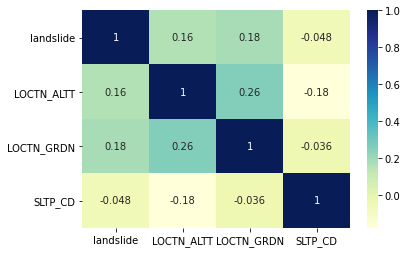

In [45]:
# 토양도 상관계수(pearson)를 사용하여 히트맵 그리기
corr_mat = sum_hg_all_2.corr(method='pearson')
sns.heatmap(corr_mat, xticklabels = corr_mat.columns, yticklabels = corr_mat.columns, annot=True, cmap='YlGnBu')

In [46]:
# 토양도가 포함되지 않은 행정동 찾기
hangjung_gubun["check_umd"] = 0

for i in range (len(sum_hg_all)):
  for j in range (len(hangjung_gubun)):
    if sum_hg_all["umd2"][i] == hangjung_gubun["umd2"][j]:
      hangjung_gubun["check_umd"][j] += 1

hangjung_gubun

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,umd,geometry,sgg,umd2,sum_cnt,landslide,check_umd
0,구룡포읍,"MULTIPOLYGON (((1184734.239 1774617.254, 11847...",포항시 남구,포항시 남구 구룡포읍,0,0,0
1,연일읍,"POLYGON ((1160923.832 1786524.018, 1160962.498...",포항시 남구,포항시 남구 연일읍,2,1,1
2,오천읍,"POLYGON ((1172424.168 1778414.742, 1172426.383...",포항시 남구,포항시 남구 오천읍,0,0,1
3,대송면,"POLYGON ((1167538.928 1778439.770, 1167541.585...",포항시 남구,포항시 남구 대송면,1,1,1
4,동해면,"MULTIPOLYGON (((1181368.959 1784712.163, 11813...",포항시 남구,포항시 남구 동해면,0,0,1
...,...,...,...,...,...,...,...
632,쌍백면,"POLYGON ((1056287.745 1722189.578, 1056335.116...",합천군,합천군 쌍백면,3,1,1
633,삼가면,"POLYGON ((1052540.942 1719533.002, 1052573.371...",합천군,합천군 삼가면,1,1,1
634,가회면,"POLYGON ((1044199.527 1722837.244, 1044218.563...",합천군,합천군 가회면,5,1,1
635,대병면,"POLYGON ((1046756.129 1730112.827, 1046808.008...",합천군,합천군 대병면,2,1,1


In [47]:
# 25개의 행정동에 토양도 데이터 없음을 확인
hangjung_gubun['check_umd'].value_counts()

1    606
0     31
Name: check_umd, dtype: int64

In [48]:
# 토양도가 없는 행정동 이름 확인
no_soil = []
for i in range (len(hangjung_gubun)):
  if hangjung_gubun['check_umd'][i] == 0:
    no_soil.append(hangjung_gubun['umd2'][i])
no_soil

['포항시 남구 구룡포읍',
 '포항시 남구 장기면',
 '포항시 남구 호미곶면',
 '포항시 남구 송도동',
 '포항시 남구 청림동',
 '포항시 남구 제철동',
 '포항시 남구 상대동',
 '포항시 남구 해도동',
 '포항시 북구 죽도동',
 '경주시 감포읍',
 '경주시 중부동',
 '경주시 황성동',
 '경주시 황오동',
 '구미시 원평1동',
 '구미시 원평2동',
 '구미시 공단2동',
 '경산시 하양읍',
 '경산시 와촌면',
 '경산시 중방동',
 '경산시 서부2동',
 '울릉군 울릉읍',
 '울릉군 서면',
 '울릉군 북면',
 '진주시 상평동',
 '진주시 신안동',
 '진주시 충무공동',
 '통영시 욕지면',
 '통영시 사량면',
 '밀양시 삼문동',
 '양산시 양주동',
 '창원시 진해구 이동']

# **합친 데이터 파일 저장**

In [49]:
# 행정동 기준으로 전처리된 토양도 합치기
merge_hg = pd.merge(sum_hg_all,hangjung_gubun,how='outer',on=['umd', 'umd2', 'sgg', 'sum_cnt', 'landslide'])
merge_hg

,index_left,umd,sgg,umd2,sum_cnt,landslide,OBJ_ID,ARA_XCRD,ARA_YCRD,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,LDMARK_STN,MAP_LABEL,geometry_x,area,geometry_y,check_umd
0,276.0,개진면,고령군,고령군 개진면,0.0,0.0,221291,323585.15,248457.02,2,24,306.1,18.7,158.6,3,12,01,1,20,02,1.0,L101,b'B\xa9\xfb',"MULTIPOLYGON (((1077730.615 1747915.354, 10777...",573125.914456,"POLYGON ((1083423.047 1748839.489, 1083442.655...",1
1,277.0,우곡면,고령군,고령군 우곡면,1.0,1.0,221860,322059.85,240132,2,24,64.1,17.7,285.2,3,07,01,1,10,03,13.0,L313,b'DRb\xa9\xfb',"MULTIPOLYGON (((1077071.844 1739931.107, 10770...",477120.157525,"POLYGON ((1075001.726 1745931.140, 1075028.704...",1
2,266.0,각북면,청도군,청도군 각북면,0.0,0.0,222469,341324,246272,1,12,573.4,22.5,15.5,3,12,01,1,10,02,1.0,L101,b'B\xa9\xfb',"POLYGON ((1096076.711 1746735.789, 1096082.000...",434384.134642,"POLYGON ((1100726.770 1749523.268, 1100739.559...",1
3,267.0,이서면,청도군,청도군 이서면,0.0,0.0,222863,353153,248292,2,26,249.5,15.1,86.6,3,12,01,1,10,02,1.0,L101,b'B\xa9\xfb',"POLYGON ((1108027.010 1747855.448, 1108032.166...",498817.582789,"POLYGON ((1108258.343 1750339.884, 1108335.531...",1
4,289.0,왜관읍,칠곡군,칠곡군 왜관읍,0.0,0.0,223263,328216,271804,2,23,85.0,20.5,133.8,3,07,01,1,10,02,13.0,L313,b'DRb\xa9\xfb',"POLYGON ((1082992.549 1772476.802, 1082995.676...",448058.883532,"POLYGON ((1086550.258 1781687.034, 1086605.088...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,NaN,욕지면,통영시,통영시 욕지면,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,"MULTIPOLYGON (((1089649.319 1611963.498, 10896...",0
633,NaN,사량면,통영시,통영시 사량면,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,"MULTIPOLYGON (((1066502.144 1641102.303, 10665...",0
634,NaN,삼문동,밀양시,밀양시 삼문동,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,"POLYGON ((1113615.781 1722342.253, 1113623.243...",0
635,NaN,양주동,양산시,양산시 양주동,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,"POLYGON ((1139172.719 1706362.526, 1139178.541...",0


In [ ]:
# 객관적으로 불필요한 변수 제거
drop_hg_all = merge_hg.drop(["geometry_x", 'geometry_y', "index_left", "area", 'check_umd'], axis=1)
# 주관적으로 불필요한 변수 제거
sum_hg_all_csv = drop_hg_all.drop(["umd", 'LDMARK_STN', "OBJ_ID", "ARA_XCRD", "ARA_YCRD", "MAP_LABEL", "sgg", "sum_cnt", "landslide"], axis=1)

In [ ]:
sum_hg_all_csv

In [ ]:
# 결측치(토양도 없는 행정동의 토양도 데이터)에 0값 배치
sum_hg_all_csv_fillna = sum_hg_all_csv.fillna(0)
# csv 파일로 저장
sum_hg_all_csv_fillna.to_csv("y_sum_hg_all.csv")

# **(기존꺼)TPGRP_TPCD 지형구분 10 평지 경사도 구하기**

In [ ]:
sum_hg_all_csv = drop_hg_all.drop(["umd", 'LDMARK_STN', "OBJ_ID", "ARA_XCRD", "ARA_YCRD", "MAP_LABEL", "sgg", "sum_cnt"], axis=1)

In [ ]:
sum_hg_all_csv[sum_hg_all_csv['TPGRP_TPCD'] == '10']

In [ ]:
sum_hg_all_csv[sum_hg_all_csv['TPGRP_TPCD'] == '07']

In [ ]:
sum_hg_all_csv['TPGRP_TPCD'].value_counts()

In [ ]:
sum_hg_all_csv.sort_values(by=['LOCTN_GRDN'])

In [ ]:
sum_hg_all_csv[sum_hg_all_csv['LOCTN_GRDN'] == 0]

In [ ]:
sum_hg_all_csv[sum_hg_all_csv['LOCTN_GRDN'] <= 5]

In [ ]:
sum_hg_all_csv[sum_hg_all_csv['LOCTN_GRDN'] >= 20]

In [ ]:
check_umd_x

# **(경사도 15이상)TPGRP_TPCD 지형구분 10 평지 경사도 구하기**

In [ ]:
sum_hg_all_csv = drop_hg_all.drop(["umd", 'LDMARK_STN', "OBJ_ID", "ARA_XCRD", "ARA_YCRD", "MAP_LABEL", "sgg", "sum_cnt"], axis=1)

In [ ]:
sum_hg_all_csv[sum_hg_all_csv['TPGRP_TPCD'] == '10']

In [ ]:
sum_hg_all_csv[sum_hg_all_csv['TPGRP_TPCD'] == '07']

In [ ]:
sum_hg_all_csv['TPGRP_TPCD'].value_counts()

In [ ]:
sum_hg_all_csv.sort_values(by=['LOCTN_GRDN'])

In [ ]:
sum_hg_all_csv[sum_hg_all_csv['LOCTN_GRDN'] == 0]

In [ ]:
sum_hg_all_csv.to_csv("sum_hg_all_g15.csv")

In [ ]:
#경로 설정 
import os
os.chdir('/content/drive/MyDrive/A2W/데이터')

In [ ]:
import pandas as pd

df = pd.read_csv("210039_한글.csv")
df

In [ ]:
df[df['umd2'] == '울릉군 서면']

In [ ]:
umd2_list = df.umd2.unique()

In [ ]:
umd2_set_test = set(df.umd2.unique())

In [ ]:
umd2_set_train = set(sum_hg_all_csv.umd2.unique())

In [ ]:
umd2_and = umd2_set_test & umd2_set_train
len(umd2_and)

In [ ]:
test = sum_hg_all_csv[sum_hg_all_csv['umd2'].isin(list(umd2_list))]
test

In [ ]:
test['SLTP_CD'].value_counts()

In [ ]:
test[test['SLTP_CD'].isin(['82', '92', '99'])]

In [ ]:
# 5개의 결측값 확인 / 추가 결측값 확인
test.info()

In [ ]:
test.tail(10)

# **(경사도 15이상, 토양형 제한)TPGRP_TPCD 지형구분 10 평지 경사도 구하기**

In [50]:
# 객관적으로 불필요한 변수 제거
drop_hg_all = merge_hg.drop(['geometry_y', "index_left", "area", 'check_umd'], axis=1)
# 주관적으로 불필요한 변수 제거
sum_hg_all_csv = drop_hg_all.drop(["umd", 'LDMARK_STN', "OBJ_ID", "ARA_XCRD", "ARA_YCRD", "MAP_LABEL", "sgg", "sum_cnt"], axis=1)

In [51]:
sum_hg_all_csv[sum_hg_all_csv['TPGRP_TPCD'] == '10']

,umd2,landslide,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,geometry_x


In [52]:
sum_hg_all_csv[sum_hg_all_csv['TPGRP_TPCD'] == '07']

,umd2,landslide,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,geometry_x
1,고령군 우곡면,1.0,2,24,64.1,17.7,285.2,3,07,01,1,10,03,13.0,"MULTIPOLYGON (((1077071.844 1739931.107, 10770..."
4,칠곡군 왜관읍,0.0,2,23,85.0,20.5,133.8,3,07,01,1,10,02,13.0,"POLYGON ((1082992.549 1772476.802, 1082995.676..."
5,칠곡군 지천면,0.0,2,23,85.0,20.5,133.8,3,07,01,1,10,02,13.0,"POLYGON ((1082992.549 1772476.802, 1082995.676..."
6,고령군 성산면,0.0,2,26,114.8,19.7,155.9,3,07,01,1,10,02,1.0,"POLYGON ((1079863.037 1754927.264, 1079865.389..."
7,고령군 다산면,0.0,2,26,114.8,19.7,155.9,3,07,01,1,10,02,1.0,"POLYGON ((1079863.037 1754927.264, 1079865.389..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,밀양시 상남면,0.0,2,25,89.7,30.7,237.3,3,07,01,1,10,02,15.0,"POLYGON ((1114084.703 1712690.608, 1114090.620..."
592,창녕군 유어면,0.0,2,24,37.6,20.8,265.7,3,07,01,1,10,03,13.0,"POLYGON ((1081669.940 1726427.171, 1081665.998..."
593,창녕군 이방면,0.0,2,26,97.9,28.0,122.8,3,07,01,1,20,03,13.0,"POLYGON ((1078793.694 1727834.120, 1078794.743..."
594,창녕군 대지면,0.0,2,24,63.7,24.9,94.9,3,07,01,1,10,02,1.0,"POLYGON ((1086533.362 1727493.003, 1086535.913..."


In [53]:
sum_hg_all_csv['TPGRP_TPCD'].value_counts()

12    392
07    166
2      29
3      19
Name: TPGRP_TPCD, dtype: int64

In [54]:
sum_hg_all_csv.sort_values(by=['LOCTN_GRDN'])

,umd2,landslide,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,geometry_x
366,사천시 동서금동,0.0,2,22,24.5,15.0,302.3,4,07,05,2,20,02,2.0,"POLYGON ((1052504.931 1658940.792, 1052506.334..."
235,의성군 다인면,0.0,2,24,145.1,15.0,213.6,2,12,01,1,10,01,24.0,"POLYGON ((1073769.784 1830623.283, 1073765.364..."
3,청도군 이서면,0.0,2,26,249.5,15.1,86.6,3,12,01,1,10,02,1.0,"POLYGON ((1108027.010 1747855.448, 1108032.166..."
365,사천시 서포면,1.0,2,22,43.8,15.2,243.5,4,07,01,1,10,03,1.0,"POLYGON ((1042634.331 1671165.157, 1042634.995..."
182,군위군 군위읍,0.0,2,22,293.4,15.3,347.6,2,12,01,1,10,01,13.0,"POLYGON ((1092184.386 1806249.945, 1092186.587..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,통영시 욕지면,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
633,통영시 사량면,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
634,밀양시 삼문동,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
635,양산시 양주동,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [55]:
sum_hg_all_csv[sum_hg_all_csv['LOCTN_GRDN'] == 0]

,umd2,landslide,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,geometry_x


In [56]:
sum_hg_all_csv.to_csv("sum_hg_all_g15_sltp_geo.csv")

In [57]:
sum_hg_all_csv = sum_hg_all_csv.rename(columns={'geometry_x':'geometry'})

In [58]:
sum_hg_all_csv.set_geometry(col='geometry', inplace=True)

In [59]:
sum_hg_all_csv.to_file("sum_hg_all_g15_sltp_geo.shp")

In [60]:
sum_hg_all_csv

,umd2,landslide,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,geometry
0,고령군 개진면,0.0,2,24,306.1,18.7,158.6,3,12,01,1,20,02,1.0,"MULTIPOLYGON (((1077730.615 1747915.354, 10777..."
1,고령군 우곡면,1.0,2,24,64.1,17.7,285.2,3,07,01,1,10,03,13.0,"MULTIPOLYGON (((1077071.844 1739931.107, 10770..."
2,청도군 각북면,0.0,1,12,573.4,22.5,15.5,3,12,01,1,10,02,1.0,"POLYGON ((1096076.711 1746735.789, 1096082.000..."
3,청도군 이서면,0.0,2,26,249.5,15.1,86.6,3,12,01,1,10,02,1.0,"POLYGON ((1108027.010 1747855.448, 1108032.166..."
4,칠곡군 왜관읍,0.0,2,23,85.0,20.5,133.8,3,07,01,1,10,02,13.0,"POLYGON ((1082992.549 1772476.802, 1082995.676..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,통영시 욕지면,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
633,통영시 사량면,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
634,밀양시 삼문동,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
635,양산시 양주동,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [74]:
sum_hg_all_csv.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 637 entries, 0 to 636
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   umd2        637 non-null    object  
 1   landslide   637 non-null    float64 
 2   PRRCK_LARG  606 non-null    object  
 3   PRRCK_MDDL  606 non-null    object  
 4   LOCTN_ALTT  606 non-null    float64 
 5   LOCTN_GRDN  606 non-null    float64 
 6   EIGHT_AGL   606 non-null    float64 
 7   CLZN_CD     606 non-null    object  
 8   TPGRP_TPCD  606 non-null    object  
 9   PRDN_FOM_C  606 non-null    object  
 10  SLANT_TYP   606 non-null    object  
 11  SLDPT_TPCD  606 non-null    object  
 12  SCSTX_CD    606 non-null    object  
 13  SLTP_CD     606 non-null    float64 
 14  geometry    606 non-null    geometry
dtypes: float64(5), geometry(1), object(9)
memory usage: 79.6+ KB


In [61]:
#경로 설정 
import os
os.chdir('/content/drive/MyDrive/A2W/데이터')

In [62]:
import pandas as pd

df = pd.read_csv("210039_한글.csv")
df

,date,sd,sgg,umd_x,1day,1day_yn,2day,2day_yn,tm,stnId,stnNm,umd_y,umd2,avgTa,minTa,maxTa,mi10MaxRn,hr1MaxRn,sumRnDur,sumRn,maxInsWs,maxWs,avgWs,minRhm,avgRhm,n99Rn,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,DMCLS_CD,AGCLS_CD,HEIGHT
0,2020-06-10,경상남도,사천시,곤명면,2020-06-11,NaN,2020-06-12,NaN,2020-06-10,192,진주,곤명면,사천시 곤명면,24.7,18.3,32.8,0.0,0.4,0.00,0.4,7.6,3.2,0.9,48.0,75.8,3.6,2,22,87.2,18.7,245.2,4,7,1,1,10,2,26,1.0,2.0,1.0,11.0,2.0,4.0,14.0
1,2020-06-11,경상남도,사천시,곤명면,2020-06-12,NaN,2020-06-13,NaN,2020-06-11,192,진주,곤명면,사천시 곤명면,24.8,20.7,31.2,0.0,1.4,0.00,3.2,5.8,2.5,0.8,62.0,85.9,0.0,2,22,87.2,18.7,245.2,4,7,1,1,10,2,26,1.0,2.0,1.0,11.0,2.0,4.0,14.0
2,2020-06-12,경상남도,사천시,곤명면,2020-06-13,NaN,2020-06-14,NaN,2020-06-12,192,진주,곤명면,사천시 곤명면,24.6,21.7,30.2,4.0,11.5,0.00,11.2,6.8,3.0,0.9,67.0,87.5,48.7,2,22,87.2,18.7,245.2,4,7,1,1,10,2,26,1.0,2.0,1.0,11.0,2.0,4.0,14.0
3,2020-06-10,경상남도,사천시,곤양면,2020-06-11,NaN,2020-06-12,NaN,2020-06-10,192,진주,곤양면,사천시 곤양면,24.7,18.3,32.8,0.0,0.4,0.00,0.4,7.6,3.2,0.9,48.0,75.8,3.6,2,22,25.0,6.6,179.5,4,7,1,1,10,2,26,1.0,2.0,1.0,11.0,2.0,4.0,16.0
4,2020-06-11,경상남도,사천시,곤양면,2020-06-12,NaN,2020-06-13,NaN,2020-06-11,192,진주,곤양면,사천시 곤양면,24.8,20.7,31.2,0.0,1.4,0.00,3.2,5.8,2.5,0.8,62.0,85.9,0.0,2,22,25.0,6.6,179.5,4,7,1,1,10,2,26,1.0,2.0,1.0,11.0,2.0,4.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3405,2020-09-06,경상북도,포항시 북구,환여동,2020-09-07,NaN,2020-09-08,NaN,2020-09-06,138,포항,환여동,포항시 북구 환여동,20.2,18.3,21.8,1.0,3.7,12.53,11.2,14.4,10.1,5.0,75.0,85.8,94.0,2,24,52.9,16.2,254.0,4,7,1,1,10,3,15,1.0,2.0,1.0,15.0,2.0,4.0,12.0
3406,2020-09-03,경상북도,포항시 북구,흥해읍,2020-09-04,NaN,2020-09-05,NaN,2020-09-03,138,포항,흥해읍,포항시 북구 흥해읍,27.5,24.4,30.9,9.0,37.1,6.70,74.4,24.1,15.5,6.2,41.0,64.0,0.0,2,26,156.1,21.3,119.7,4,12,1,1,10,2,15,1.0,1.0,2.0,44.0,1.0,2.0,10.0
3407,2020-09-04,경상북도,포항시 북구,흥해읍,2020-09-05,NaN,2020-09-06,NaN,2020-09-04,138,포항,흥해읍,포항시 북구 흥해읍,25.4,21.1,30.7,0.0,0.0,0.00,0.0,6.6,4.9,2.4,36.0,58.6,0.0,2,26,156.1,21.3,119.7,4,12,1,1,10,2,15,1.0,1.0,2.0,44.0,1.0,2.0,10.0
3408,2020-09-05,경상북도,포항시 북구,흥해읍,2020-09-06,NaN,2020-09-07,NaN,2020-09-05,138,포항,흥해읍,포항시 북구 흥해읍,20.3,18.1,22.9,1.0,4.1,14.67,19.9,5.2,3.9,1.3,72.0,86.1,21.6,2,26,156.1,21.3,119.7,4,12,1,1,10,2,15,1.0,1.0,2.0,44.0,1.0,2.0,10.0


In [63]:
df[df['umd2'] == '울릉군 서면']

,date,sd,sgg,umd_x,1day,1day_yn,2day,2day_yn,tm,stnId,stnNm,umd_y,umd2,avgTa,minTa,maxTa,mi10MaxRn,hr1MaxRn,sumRnDur,sumRn,maxInsWs,maxWs,avgWs,minRhm,avgRhm,n99Rn,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,DMCLS_CD,AGCLS_CD,HEIGHT


In [64]:
umd2_list = df.umd2.unique()

In [65]:
umd2_set_test = set(df.umd2.unique())

In [66]:
umd2_set_train = set(sum_hg_all_csv.umd2.unique())

In [67]:
umd2_set_train = set(sum_hg_all_g15_sltp_geo.umd2.unique())

In [68]:
umd2_and = umd2_set_test & umd2_set_train
len(umd2_and)

0

In [69]:
test = sum_hg_all_csv[sum_hg_all_csv['umd2'].isin(list(umd2_list))]
test

,umd2,landslide,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,geometry
1,고령군 우곡면,1.0,2,24,64.1,17.7,285.2,3,07,01,1,10,03,13.0,"MULTIPOLYGON (((1077071.844 1739931.107, 10770..."
3,청도군 이서면,0.0,2,26,249.5,15.1,86.6,3,12,01,1,10,02,1.0,"POLYGON ((1108027.010 1747855.448, 1108032.166..."
10,경산시 남천면,0.0,1,12,197.4,20.1,156.4,3,12,03,3,20,02,2.0,"POLYGON ((1108560.814 1755926.365, 1108561.923..."
13,영천시 청통면,1.0,2,23,119.1,15.3,285.3,3,07,01,1,10,03,15.0,"POLYGON ((1124693.737 1778735.781, 1124697.721..."
14,영천시 완산동,1.0,2,23,125.3,17.3,352.2,3,12,01,1,10,03,15.0,"POLYGON ((1131745.351 1774790.172, 1131729.604..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,포항시 남구 장기면,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
611,포항시 남구 제철동,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
615,경주시 감포읍,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
626,울릉군 울릉읍,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [70]:
test['SLTP_CD'].value_counts()

1.0     133
2.0      86
15.0     16
13.0     13
16.0     12
14.0     11
3.0       6
26.0      6
24.0      2
6.0       1
28.0      1
Name: SLTP_CD, dtype: int64

In [71]:
test[test['SLTP_CD'].isin(['82', '92', '99'])]

,umd2,landslide,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,geometry


In [72]:
# 5개의 결측값 확인 / 추가 결측값 없어짐
test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 292 entries, 1 to 628
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   umd2        292 non-null    object  
 1   landslide   292 non-null    float64 
 2   PRRCK_LARG  287 non-null    object  
 3   PRRCK_MDDL  287 non-null    object  
 4   LOCTN_ALTT  287 non-null    float64 
 5   LOCTN_GRDN  287 non-null    float64 
 6   EIGHT_AGL   287 non-null    float64 
 7   CLZN_CD     287 non-null    object  
 8   TPGRP_TPCD  287 non-null    object  
 9   PRDN_FOM_C  287 non-null    object  
 10  SLANT_TYP   287 non-null    object  
 11  SLDPT_TPCD  287 non-null    object  
 12  SCSTX_CD    287 non-null    object  
 13  SLTP_CD     287 non-null    float64 
 14  geometry    287 non-null    geometry
dtypes: float64(5), geometry(1), object(9)
memory usage: 36.5+ KB


In [73]:
test.tail(10)

,umd2,landslide,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,geometry
600,밀양시 산내면,0.0,1,14,643.5,29.8,287.2,3,12,01,1,30,03,2.0,"POLYGON ((1132087.520 1732358.919, 1132089.503..."
601,밀양시 무안면,1.0,1,14,152.8,19.6,203.6,3,12,01,1,10,02,1.0,"POLYGON ((1102570.544 1726427.125, 1102570.702..."
602,밀양시 청도면,1.0,1,14,152.8,19.6,203.6,3,12,01,1,10,02,1.0,"POLYGON ((1102570.544 1726427.125, 1102570.702..."
603,밀양시 부북면,1.0,2,25,388.7,21.6,8.9,3,12,01,1,10,02,1.0,"POLYGON ((1112468.080 1729538.316, 1112459.764..."
605,창녕군 성산면,1.0,1,11,445.3,22.7,214.5,3,12,01,1,10,02,1.0,"POLYGON ((1092164.114 1739614.824, 1092166.225..."
607,포항시 남구 장기면,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
611,포항시 남구 제철동,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
615,경주시 감포읍,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
626,울릉군 울릉읍,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
628,울릉군 북면,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [75]:
test.set_geometry(col='geometry', inplace=True)
test.to_file("sum_hg_all_test_geo.shp",encoding='utf-8')

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


# **shp 파일 불러오기 확인**

In [76]:
#경로 설정 
import os
os.chdir('/content/drive/MyDrive/A2W/데이터')

In [77]:
sum_hg_all_g15_sltp_geo = gpd.GeoDataFrame.from_file("sum_hg_all_test_geo.shp", encoding = 'utf-8')
sum_hg_all_g15_sltp_geo

,umd2,landslide,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,EIGHT_AGL,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLANT_TYP,SLDPT_TPCD,SCSTX_CD,SLTP_CD,geometry
0,고령군 우곡면,1.0,2,24,64.1,17.7,285.2,3,07,01,1,10,03,13.0,"MULTIPOLYGON (((1077071.844 1739931.107, 10770..."
1,청도군 이서면,0.0,2,26,249.5,15.1,86.6,3,12,01,1,10,02,1.0,"POLYGON ((1108027.010 1747855.448, 1108032.166..."
2,경산시 남천면,0.0,1,12,197.4,20.1,156.4,3,12,03,3,20,02,2.0,"POLYGON ((1108560.814 1755926.365, 1108561.923..."
3,영천시 청통면,1.0,2,23,119.1,15.3,285.3,3,07,01,1,10,03,15.0,"POLYGON ((1124693.737 1778735.781, 1124697.721..."
4,영천시 완산동,1.0,2,23,125.3,17.3,352.2,3,12,01,1,10,03,15.0,"POLYGON ((1131745.351 1774790.172, 1131729.604..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,포항시 남구 장기면,1.0,None,None,NaN,NaN,NaN,None,None,None,None,None,None,NaN,None
288,포항시 남구 제철동,1.0,None,None,NaN,NaN,NaN,None,None,None,None,None,None,NaN,None
289,경주시 감포읍,1.0,None,None,NaN,NaN,NaN,None,None,None,None,None,None,NaN,None
290,울릉군 울릉읍,1.0,None,None,NaN,NaN,NaN,None,None,None,None,None,None,NaN,None


In [78]:
sum_hg_all_g15_sltp_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   umd2        292 non-null    object  
 1   landslide   292 non-null    float64 
 2   PRRCK_LARG  287 non-null    object  
 3   PRRCK_MDDL  287 non-null    object  
 4   LOCTN_ALTT  287 non-null    float64 
 5   LOCTN_GRDN  287 non-null    float64 
 6   EIGHT_AGL   287 non-null    float64 
 7   CLZN_CD     287 non-null    object  
 8   TPGRP_TPCD  287 non-null    object  
 9   PRDN_FOM_C  287 non-null    object  
 10  SLANT_TYP   287 non-null    object  
 11  SLDPT_TPCD  287 non-null    object  
 12  SCSTX_CD    287 non-null    object  
 13  SLTP_CD     287 non-null    float64 
 14  geometry    287 non-null    geometry
dtypes: float64(5), geometry(1), object(9)
memory usage: 34.3+ KB
